# Modelo RandomForest

### Autores: Matías Corredoira de Soto y Pablo Revuelta Stobbs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, recall_score, roc_auc_score, plot_precision_recall_curve
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
import scikitplot as skplt

In [2]:
pathfile1 = '../data/loans_ind_clean.csv'

In [3]:
loans_ind = pd.read_csv(pathfile1, engine = 'python')
loans_ind.head()

,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,title,...,num_sats,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico_avg
0,36.0,359.26,A,6.0,OWN,153000.0,Not Verified,1.0,credit_card,Credit card refinancing,...,20,2,95.7,11.1,1,528172,100865,28100,120572,722.0
1,36.0,285.70,E,2.0,RENT,50000.0,Source Verified,1.0,debt_consolidation,Debt consolidation,...,4,0,80.0,100.0,0,7600,5588,3600,4000,687.0
2,36.0,232.79,A,7.0,MORTGAGE,110000.0,Not Verified,1.0,debt_consolidation,Debt consolidation,...,19,3,100.0,8.3,0,350617,45955,83700,32239,712.0
3,60.0,243.29,C,7.0,RENT,51979.0,Source Verified,1.0,debt_consolidation,Debt consolidation,...,15,3,100.0,0.0,2,34200,10956,18800,5500,692.0
4,36.0,492.34,C,7.0,MORTGAGE,75000.0,Verified,1.0,debt_consolidation,Debt consolidation,...,4,3,90.0,100.0,0,170591,27684,3000,30321,687.0


In [4]:
y = loans_ind['loan_status']
x = loans_ind.drop('loan_status', axis = 1)
x_list = list(x.columns)

In [5]:
numeric_transformer_0 = Pipeline(steps = [
    ('imputer_0', SimpleImputer(strategy = 'constant')),
    ('escalar', StandardScaler())
])

numeric_transformer_median = Pipeline(steps = [
    ('imputer_median', SimpleImputer(strategy = 'median')),
    ('escalar1', StandardScaler())
])

categoric_transformer  = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'sin_info')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore')) # mirar esto de handle_unknowns
])

In [6]:
numeric_features_0 = x.loc[:, ['bc_open_to_buy', 'mths_since_recent_bc', 'revol_util', 'emp_length', 'term', 'installment', 'annual_inc', 'inq_last_6mths',
                                      'mths_since_last_delinq', 'open_acc', 'revol_bal', 'total_acc', 'tot_cur_bal', 'acc_open_past_24mths',
                                       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
                                      'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_inq', 'num_actv_rev_tl',
                                       'num_sats', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tot_hi_cred_lim',
                                      'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'fico_avg']].columns

numeric_features_median = x.loc[:, ['percent_bc_gt_75',
                                            'bc_util',
                                            'avg_cur_bal',
                                            'num_rev_accts',
                                            'dti']].columns


categoric_features = x.select_dtypes(include = ['object']).columns

In [7]:
preprocessor = ColumnTransformer(
        transformers = [
            ('num_0', numeric_transformer_0, numeric_features_0),
            ('num_median', numeric_transformer_median, numeric_features_median),
            ('cat', categoric_transformer, categoric_features)
        ]
)

In [8]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42)


In [9]:
test_y.value_counts()

1.0    85984
0.0    29152
Name: loan_status, dtype: int64

In [10]:
rand_for = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', RandomForestClassifier())
                    ])

In [11]:
%%time

rand_for.fit(train_x, train_y)

Wall time: 44min 26s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_0',
                                                  Pipeline(steps=[('imputer_0',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('escalar',
                                                                   StandardScaler())]),
                                                  Index(['bc_open_to_buy', 'mths_since_recent_bc', 'revol_util', 'emp_length',
       'term', 'installment', 'annual_inc', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'revol_bal', 'total_ac...
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='sin_info',
                                                           

In [12]:
print("model score: %.3f" % rand_for.score(test_x, test_y))

model score: 0.755


In [13]:
pred_y = rand_for.predict(test_x)

In [14]:
filename = 'model_rand_for_1.sav'

In [15]:
pickle.dump(rand_for, open(filename, 'wb'))

In [16]:
rand_for = pickle.load(open('../modelos/model_rand_for_1.sav', 'rb'))

# Análisis

In [17]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.61      0.09      0.16     29152
         1.0       0.76      0.98      0.86     85984

    accuracy                           0.76    115136
   macro avg       0.69      0.54      0.51    115136
weighted avg       0.72      0.76      0.68    115136



## Matriz de confusión

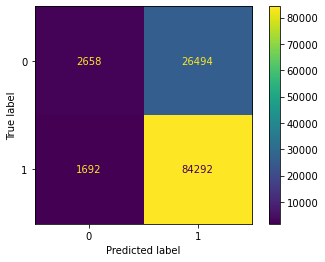

In [18]:
confusion_matrix = confusion_matrix(test_y, pred_y)
ConfusionMatrixDisplay(confusion_matrix).plot()

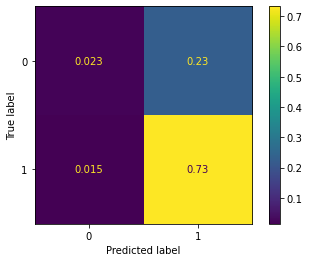

In [19]:
ConfusionMatrixDisplay(confusion_matrix/np.sum(confusion_matrix)).plot()

La matriz de confusión muestra un buen resultado para la clase 1 sin embargo para la clase 0 su porcentaje de acierto es prácticamente nulo.

## Curva ROC

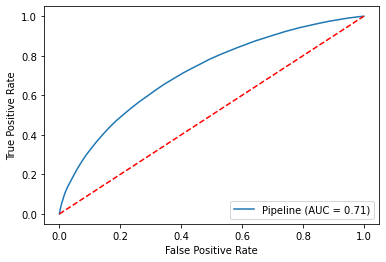

In [20]:
metrics.plot_roc_curve(rand_for, test_x, test_y)
plt.plot([0, 1], [0, 1], 'r--')

## Precission Recall

In [21]:

precision, recall, thresholds = precision_recall_curve(test_y, pred_y)

area = auc(recall, precision)

print('------------ Results for RandomForest ---------------')
print('recall_score:', recall_score(test_y, pred_y))
print('roc_auc_score:',roc_auc_score(test_y, pred_y))
print("Area Under P-R Curve: ",area)

------------ Results for RandomForest ---------------
recall_score: 0.9803219203572757
roc_auc_score: 0.5357495990370352
Area Under P-R Curve:  0.8779359220893399


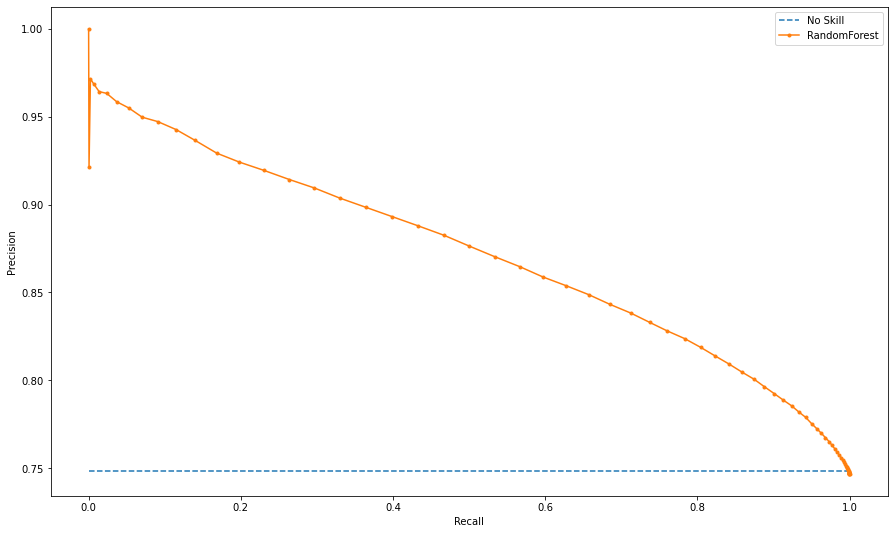

In [22]:
# predict probabilities
yhat = rand_for.predict_proba(test_x)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
plt.figure(figsize=(15,9))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(test_y, pos_probs)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='RandomForest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

Se observa que el recall aumenta en gran medida cuando disminuye en menor proporción la precisión del modelo, de todos modos, al principio, cuando disminuye la precisión el recall no mejora. Esto indica que el modelo actua de forma adecuada sobre la característica primordial del modelo, que en este caso es la de entregar el crédito, por lo que es de esperar buenos resultados para la misma.

## Gain curve

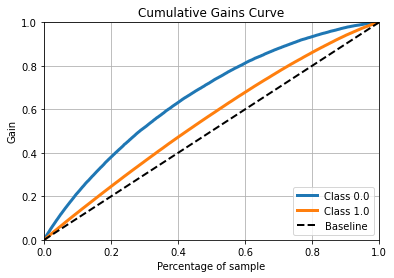

In [23]:
predicted_probabilities = rand_for.predict_proba(test_x)
skplt.metrics.plot_cumulative_gain(test_y, predicted_probabilities)
plt.show()

Se observa que para las observaciones de la clase 0 tiene una utilidad marginal mayor a principio, aproximadamente hasta un 50 % de la muestra, mientras que para la clase 1 no se diferencia mucho de la base.

# Modelo joint loans

In [24]:
pathfile1 = '../data/loans_joint_clean.csv'

In [25]:
loans_joint = pd.read_csv(pathfile1, engine = 'python')
loans_joint.head()

,Unnamed: 0,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,fico_avg
0,0,36.0,486.98,B,3.0,MORTGAGE,115000.0,Not Verified,1.0,car,...,Jul-1995,0.0,2.0,8.0,7.7,0.0,27.0,0.0,0.0,682.0
1,1,36.0,112.83,B,3.0,MORTGAGE,40000.0,Verified,1.0,debt_consolidation,...,Jan-2007,0.0,2.0,18.0,50.0,3.0,20.0,0.0,0.0,672.0
2,2,36.0,285.70,E,1.0,RENT,24000.0,Not Verified,0.0,other,...,Sep-2005,0.0,0.0,23.0,NaN,23.0,2.0,1.0,3.0,662.0
3,3,60.0,437.92,C,5.0,MORTGAGE,55000.0,Source Verified,1.0,home_improvement,...,Jun-2006,2.0,3.0,23.0,42.1,13.0,13.0,0.0,2.0,697.0
4,4,36.0,817.41,B,NaN,MORTGAGE,32000.0,Verified,0.0,credit_card,...,Oct-1997,0.0,2.0,14.0,76.1,2.0,24.0,0.0,0.0,692.0


In [26]:
y_joint = loans_joint['loan_status']
x_joint = loans_joint.drop('loan_status', axis = 1)

In [27]:
numeric_transformer_0_joint = Pipeline(steps = [
    ('imputer_0_joint', SimpleImputer(strategy = 'constant')),
    ('escalar_joint', StandardScaler())
])


categoric_transformer_joint  = Pipeline(steps = [
    ('imputer_joint', SimpleImputer(strategy = 'constant', fill_value = 'sin_info')),
    ('onehot_joint', OneHotEncoder(handle_unknown = 'ignore')) # mirar esto de handle_unknowns
])

In [28]:
numeric_features_0_joint = x_joint.select_dtypes(include=['int64', 'float64']).columns

categoric_features_joint = x_joint.select_dtypes(include = ['object']).columns

In [29]:
preprocessor_joint = ColumnTransformer(
        transformers = [
            ('num_0_joint', numeric_transformer_0_joint, numeric_features_0_joint),
            ('cat_joint', categoric_transformer_joint, categoric_features_joint)
        ]
)

In [30]:
from sklearn.model_selection import train_test_split

train_x_joint, test_x_joint, train_y_joint, test_y_joint = train_test_split(x_joint,
                                                    y_joint,
                                                    test_size = 0.25,
                                                    random_state = 42)


In [31]:
rf_joint = Pipeline(steps=[('preprocessor_joint', preprocessor_joint),
                     ('classifier_joint', RandomForestClassifier())
                    ])

In [32]:
%%time

rf_joint.fit(train_x_joint, train_y_joint)

Wall time: 690 ms


Pipeline(steps=[('preprocessor_joint',
                 ColumnTransformer(transformers=[('num_0_joint',
                                                  Pipeline(steps=[('imputer_0_joint',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('escalar_joint',
                                                                   StandardScaler())]),
                                                  Index(['Unnamed: 0', 'term', 'installment', 'emp_length', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc',
       'pub_rec', 'revol_b...
                                                                   SimpleImputer(fill_value='sin_info',
                                                                                 strategy='constant')),
                                                                  ('onehot_joint',
      

In [33]:
print("model score: %.3f" % rf_joint.score(test_x_joint, test_y_joint))

model score: 0.654


In [34]:
filename_joint = 'model_rf_1_joint.sav'

In [35]:
pickle.dump(rf_joint, open(filename_joint, 'wb'))